<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right!important;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Leroy Deniz Pedreira
</div>

# Práctica:

## Implementación de un agente para la robótica espacial

A lo largo de las tres partes de la asignatura hemos entrado en contacto con diferentes clases de algoritmos de aprendizaje por refuerzo que permiten solucionar problemas de control en una gran variedad de entornos.
Esta práctica, que se va a extender a lo largo de un mes aproximadamente, da la posibilidad de enfrentarse al diseño de un agente para solucionar un caso específico de robótica.

Atacaremos el problema a partir de la exploración del entorno y sus observaciones. Luego, pasaremos a la selección del algoritmo más oportuno para solucionar el entorno en cuestión. Finalmente, pasaremos por el entrenamiento y la prueba del agente, hasta llegar al análisis de su rendimiento.

Para ello, se presentará antes el entorno de referencia, y luego, se pasará a la implementación de un agente Deep Q-Network (DQN) que lo solucione. Después de estas dos primeras fases de toma de contacto con el problema, se buscará otro agente que pueda mejorar el rendimiento del agente DQN anteriormente implementado.

## Entorno 

Estamos trabajando sobre un problema de robótica espacial y en particular queremos solucionar el problema de aterrizaje propio, por ejemplo, de drones autónomos.

Para ello, se elige lunar-lander como entorno simplificado. El entorno se puede encontrar en el siguiente enlace: https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

Lunar Lander consiste en una nave espacial que debe aterrizar en un lugar determinado del campo de observación. El agente conduce la nave y su objetivo es conseguir aterrizar en la pista de aterrizaje, coordenadas (0,0), y llegar con velocidad 0.

La nave consta de tres motores (izquierda, derecha y el principal que tiene debajo) que le permiten ir corrigiendo su rumbo hasta llegar a destino.

Las acciones que puede realizar la nave (espacio de acciones) son discretas.

Las recompensas obtenidas a lo largo del proceso de aterrizaje dependen de las acciones que se toman y del resultado que se deriva de ellas.

- Desplazarse de arriba a abajo, hasta la zona de aterrizaje, puede resultar en [+100,+140] puntos
- Si se estrella al suelo, pierde -100 puntos
- Si consigue aterrizar en la zona de aterrizaje (velocidad 0), gana +100 puntos
- Si aterriza, pero no en la zona de aterrizaje (fuera de las banderas amarillas) se pierden puntos
- El contacto de una pata con el suelo recibe +10 puntos (si se pierde contacto después de aterrizar, se pierden puntos)
- Cada vez que enciende el motor principal pierde -0.3 puntos
- Cada vez que enciende uno de los motores de izquierda o derecha, pierde -0.03 puntos

La solución óptima es aquella en la que el agente, con un desplazamiento eficiente, consigue aterrizar en la zona de aterrizaje (0,0), tocando con las dos patas en el suelo y con velocidad nula. Se considera que el agente ha aprendido a realizar la tarea (i.e. el “juego” termina) cuando obtiene una media de al menos 200 puntos durante 100 episodios consecutivos.

In [1]:
%%capture
!pip3 install pygame
!pip3 install "gym[box2d]"
!pip3 install imageio
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install rgb2gray

In [3]:
# Instalación de librerías.
import warnings
import pygame
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
pygame.display.set_mode((640,480))
import pdb
import gym

import time
import torch
import matplotlib.pyplot as plt

import numpy as np
import os
import random
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
from IPython import display

from skimage import transform
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

from math import inf
from tqdm import tqdm # Librería para mostrar avance en iteraciones
import datetime # Para medir el tiempo de ejecución
import statistics as std # Para utilizar funciones como mean
from collections import deque # Manejo de pilas con un máximo de n elementos, definidos
from IPython.display import Image as print_gif

# Comprobación de la versión de GYM instalada
print('La versión de gym instala: ' + gym.__version__)
# Comprobación de entorno con gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("El entorno utiliza: ", device)


# Constantes
MAX_EPISODES = 1500
MAX_SCORE = 200

La versión de gym instala: 0.25.0
El entorno utiliza:  cpu


## Ejercicio 1.1

Se pide explorar el entorno yt representar una ejecución aleatoria.

In [4]:
# Se crea el entorno
warnings.filterwarnings('ignore')
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=0)

array([ 0.00570612,  1.3990337 ,  0.5779653 , -0.5282997 , -0.0066053 ,
       -0.13091765,  0.        ,  0.        ], dtype=float32)

In [5]:
print(f"Umbral de recompensas: {env.reward_range}")
print(f"Máximo número de pasos por episodio: {env.spec.max_episode_steps}")

Umbral de recompensas: (-inf, inf)
Máximo número de pasos por episodio: 1000


El espacio de acciones de este entorno consta de 4 opciones:


- no hacer nada
- activar el motor izquierdo
- activar el motor principal debajo
- activar el motor derecho

In [6]:
print(f"Dimensión del espacio de acciones: {env.action_space.n}")

Dimensión del espacio de acciones: 4


In [9]:
#Método para generar la imagen a partir de un estado con un texto informativo.
def _label_with_text(frame):
    '''
    frame: estado de un entorno GYM.
    '''
    im = Image.fromarray(frame[0])
    drawer = ImageDraw.Draw(im)
    return im
    
    
#Método que permite crear un gif con la evolución de una partida dado un entorno GYM.
def save_agent_gif(env, filename='random_lunar_lander', network = None):
    frames = []
    done = False
    state = env.reset()
    ###########################################
    #Jugar una partida aleatoria.
    while not done:
        action = env.action_space.sample() if network is None else network.get_action(state)
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        state, _, done, _ = env.step(action)
    ##############################################

    env.close()
    imageio.mimwrite(os.path.join('./videos/', f'{filename}.gif'), frames, fps=60)
    
try:
    os.makedirs('videos')
except:
    pass
save_agent_gif(env)

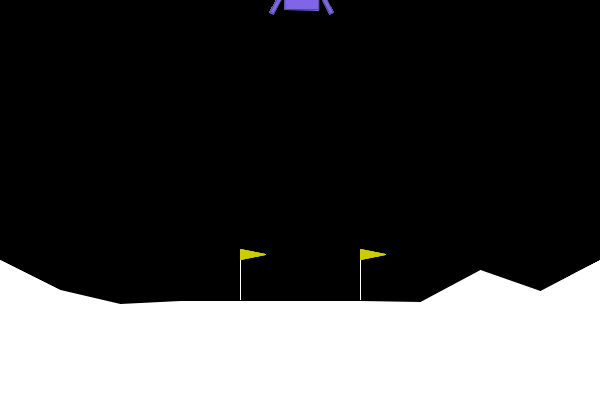

In [10]:
print_gif('videos/random_lunar_lander.gif')

## Ejercicio 1.2

Explicar los posibles espacios de observaciones y de acciones (informe escrito).

Cada estado es un vector de ocho dimensiones, definidos en el siguiente orden:

- posición _x_ de la nave
- posición _y_ de la nave
- velicidad lineal en _x_
- velocidad lineal en _y_
- ángulo de movimiento
- velocidad angular de la nave
- booleano que se activa si la pata izquierda toca el suelo lunar 
- booleano que se activa si la pata derecha toca el suelo lunar 

El vector _observation\_low_ ofrece las cotas inferiores que pueden tomar cada uno de los parémetros, mostrando lo opuesto el vector _observation\_high_.

In [11]:
print(f"Observation shape: {env.observation_space.shape}")
print(f"Observation high: {env.observation_space.high}")
print(f"Observation low: {env.observation_space.low}")

Observation shape: (8,)
Observation high: [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
Observation low: [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]


## Ejercicio 2.1

Implementar un agente DQN para el entorno lunar-lander.

### Definición de la Red Neuronal

In [12]:
class DQNNetwork(nn.Module):
    
    def __init__(self, env, learning_rate=1e-3):
        super().__init__()
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        device: cpu o cuda
        red_lineal: definición de la red lineal
        """
        #######################################
        ###TODO: inicialización y modelo###
        self.input_shape = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
            
            
        #######################################
        ##TODO: Construcción de la red neuronal lineal completamente conectada
        self.red_lineal = nn.Sequential(
            nn.Linear(self.input_shape, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, self.n_outputs, bias=True)
        )

        if torch.cuda.is_available():
            self.red_lineal.cuda()


        #######################################
        ##TODO: Inicializar el optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)
            action = torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.red_lineal(state_t)


### Definición del Agente

In [13]:
from collections import namedtuple, deque

class experienceReplayBuffer:
    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Use el operador asterisco para desempaquetar deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

In [14]:
from copy import deepcopy, copy

class DQNAgent:
    ###### Declaración de variables ##################
    def __init__(
        self,
        env,
        main_network,
        buffer,
        reward_threshold,
        epsilon=0.1,
        eps_decay=0.99,
        batch_size=32,
        nblock=100,
    ):
        """
        Params
        ======
        env: entorno
        main_network: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa
        """
        if torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"
            
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(
            main_network
        )  # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = nblock  # últimos episodios a evaluar
        self.reward_threshold = reward_threshold
        self.initialize()

    ##### Inicializar variables extra que se necesiten######
    def initialize(self):
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.epsilon_history = []
        self.update_loss = []
        self.losses = []
        self.mean_training_rewards = []
        self.training_rewards = []
        self.state0 = self.env.reset()

    ###### Tomar nueva acción ###############################################
    def take_step(self, eps, mode="train"):
        if mode == "explore":
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(
                self.state0, eps
            )  # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1

        # Realización de la acción y obtención del nuevo estado y la recompensa.
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(
            self.state0, action, reward, done, new_state
        )  # guardar experiencia en el buffer
        self.state0 = new_state

        # Resetear entorno 'if done'
        if done:
            self.state0 = env.reset()
        return done

    ## Entrenamiento
    def train(
        self,
        gamma=0.99,
        max_episodes=50000,
        batch_size=32,
        dnn_update_frequency=4,
        dnn_sync_frequency=2000,
        min_episodios=250,
        min_epsilon=0.01,
    ):
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode="explore")

        episode = 0
        training = True
        print("Training...")
        maximo = -inf
        while training:
            self.state0 = env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode="train")
                
                #################################################################################
                ### Actualizar red principal según la frecuencia establecida#####
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ########################################################################################
                ### Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(self.main_network.state_dict())
                    self.sync_eps.append(episode)

                if gamedone:
                    episode += 1
                    ##################################################################
                    ######## Almacenar epsilon, training rewards y loss   #######
                    self.epsilon_history.append(self.epsilon)
                    self.training_rewards.append(self.total_reward)
                    self.losses.append(np.mean(self.update_loss))
                    self.update_loss = []

                    #######################################################################################
                    ### Calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    mean_rewards = np.mean(  # calculamos la media de recompensa de los últimos X episodios
                        self.training_rewards[-self.nblock :]
                    )
                    self.mean_training_rewards.append(mean_rewards)
                    maximo = mean_rewards if mean_rewards > maximo else maximo

                    ##################################################################

                    print(f"\rEpisode {episode} Mean Rewards {mean_rewards:.2f} Epsilon {self.epsilon} , Maximo {maximo:.2f}\t\t", end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print("\nEpisode limit reached.")
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if (
                        mean_rewards >= self.reward_threshold
                        and min_episodios < episode
                    ):
                        training = False
                        print(f"\nEnvironment solved in {episode} episodes!")
                        break

                    #################################################################################
                    ###### Actualizar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

    ####################################
    ##### Cálculo de la pérdida ####
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device)
        actions_vals = (
            torch.LongTensor(np.array(actions)).to(device=self.device).reshape(-1, 1)
        )
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q de la red objetivo El parametro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states), dim=-1)[
            0
        ].detach()
        qvals_next[dones_t] = 0  # 0 en estados terminales


        #################################################################################
        ###TODO: Calculamos ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals

        # Cálculo de pérdida
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1, 1))
        return loss

    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(
            batch_size=self.batch_size
        )  # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch)  # calculamos la pérdida
        loss.backward()  # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step()  # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.device == "cuda":
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

## Ejercicio 2.2
Entrenar el agente DQN y buscar los valores de los hiperparámetros que obtengan un alto rendimiento del agente. Para ello, es necesario listar los hiperparámetros bajo estudio y presentar las gráficas de las métricas que describen el aprendizaje.

Se entrena inicialmente el agente con los valores por defectpo de la práctica 2.

In [ ]:
lr = 0.001            #Velocidad de aprendizaje
BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
BURN_IN = 100         #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MIN_EPISODES = 250    #Número mínimo de episodios
DNN_UPD = 100         #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

# Cargar el buffer de repetición de experiencias
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Cargar el modelo de red neuronal
dqn_0 = DQNNetwork(env, learning_rate=lr)

# Cargar el agente
agent_0 = DQNAgent(env, dqn_0, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# Entrenar el agente
agent_0.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...
Episode 664 Mean Rewards -101.23 Epsilon 0.036033175291307735 , Maximo -99.98			

### Exportación del modelo

In [ ]:
torch.save(agent_0.main_network.state_dict(), './models/dqn_agent_0.pth')

### Partida a través del modelo obtenido

In [ ]:
save_agent_gif(env, 'dqn_lunar_lander_0', agent_0.target_network)
print_gif('videos/dqn_lunar_lander_0.gif')

### Recompensas obtenidas a lo largo del entrenamiento

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(agent_0.training_rewards, label='Rewards')
plt.plot(agent_0.mean_training_rewards, label='Mean Rewards')
plt.axhline(agent_0.reward_threshold, color='r', label="Reward threshold")
plt.axhline(0, color='#FF000099', label="Min positive reward")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(loc="upper right")
plt.show()

### Evolución de la pérdida a lo largo del entrenamiento

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(agent_0.losses, label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

### Evolución de epsilon a lo largo del entrenamiento

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(agent_0.epsilon_history, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend(loc="upper right")
plt.show()

## Juego de pruebas para mejorar

<table>
    <tr>
        <td></td>
        <td>Configuración 0</td>
        <td>Configuración 1</td>
        <td>Configuración 2</td>
        <td>Configuración 3</td>
    </tr>
    <tr>
        <td>lr</td>
        <td>0.001</td>
        <td>0.001</td>
        <td>0.1</td>
        <td>0.01</td>
    </tr>
    <tr>
        <td>DNN_UPD</td>
        <td>100</td>
        <td>100</td>
        <td>100</td>
        <td>100</td>
    </tr>
    <tr>
        <td>DNN_SYNC</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
    </tr>
    <tr>
        <td>BATCH_SIZE</td>
        <td>32</td>
        <td>64</td>
        <td>32</td>
        <td>10</td>
    </tr>
    <tr>
        <td>GAMMA</td>
        <td>0.99</td>
        <td>0.99</td>
        <td>0.001</td>
        <td>0.99</td>
    </tr>
    <tr>
        <td>MAX_EPISODES</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
    </tr>
    <tr>
        <td><strong>MEAN TRAINING REWARD</strong></td>
        <td><strong>-177.70</strong></td>
        <td><strong>0</strong></td>
        <td><strong>-265.79</strong></td>
        <td><strong>0</strong></td>
    </tr>
    <tr>
        <td><strong>MAX REWARD</strong></td>
        <td><strong>201.58</strong></td>
        <td><strong>0</strong></td>
        <td><strong>40.48</strong></td>
        <td><strong>0</strong></td>
    </tr>
</table>

### Configuración 1

In [ ]:
lr = 0.001            #Velocidad de aprendizaje
BATCH_SIZE = 64       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
BURN_IN = 100         #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MIN_EPISODES = 250    #Número mínimo de episodios
DNN_UPD = 100         #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

# Cargar el buffer de repetición de experiencias
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Cargar el modelo de red neuronal
dqn_1 = DQNNetwork(env, learning_rate=lr)

# Cargar el agente
agent_1 = DQNAgent(env, dqn_1, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# Entrenar el agente
agent_1.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

In [ ]:
torch.save(agent_1.main_network.state_dict(), './models/dqn_agent_1.pth')
save_agent_gif(env, 'dqn_lunar_lander_1', agent_1.target_network)
print_gif('videos/dqn_lunar_lander_01.gif')

### Configuración 2

In [ ]:
lr = 0.1            #Velocidad de aprendizaje
BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.001          #Valor gamma de la ecuación de Bellman
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
BURN_IN = 100         #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MIN_EPISODES = 250    #Número mínimo de episodios
DNN_UPD = 100         #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

# Cargar el buffer de repetición de experiencias
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Cargar el modelo de red neuronal
dqn_2 = DQNNetwork(env, learning_rate=lr)

# Cargar el agente
agent_2 = DQNAgent(env, dqn_2, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# Entrenar el agente
agent_2.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

In [ ]:
torch.save(agent_2.main_network.state_dict(), './models/dqn_agent_2.pth')
save_agent_gif(env, 'dqn_lunar_lander_2', agent_2.target_network)
print_gif('videos/dqn_lunar_lander_2.gif')

### Configuración 3

In [ ]:
lr = 0.01            #Velocidad de aprendizaje
BATCH_SIZE = 10       #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .995  #Decaimiento de epsilon
BURN_IN = 100         #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
MIN_EPISODES = 250    #Número mínimo de episodios
DNN_UPD = 100         #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 5000       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

# Cargar el buffer de repetición de experiencias
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Cargar el modelo de red neuronal
dqn_3 = DQNNetwork(env, learning_rate=lr)

# Cargar el agente
agent_3 = DQNAgent(env, dqn_3, buffer, MAX_SCORE, EPSILON, EPSILON_DECAY, BATCH_SIZE)

# Entrenar el agente
agent_3.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

In [ ]:
torch.save(agent_3.main_network.state_dict(), './models/dqn_agent_3.pth')
save_agent_gif(env, 'dqn_lunar_lander_3', agent_3.target_network)
print_gif('videos/dqn_lunar_lander_3.gif')

### Comparación entre los tres modelos

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(agent_0.mean_training_rewards, label='DQN Configuración 0')
plt.plot(agent_1.mean_training_rewards, label='DQN Configuración 1')
plt.plot(agent_2.mean_training_rewards, label='DQN Configuración 2')
plt.plot(agent_3.mean_training_rewards, label='DQN Configuración 3')
plt.axhline(200, color='r', label="Reward threshold")
plt.axhline(0, color='#FF000099', label="Min positive reward")
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.legend(loc="upper left")
plt.show()

## Ejercicio 2.3
Probar el agente entrenado en el entorno de prueba. Visualizar su comportamiento (a través de gráficas de las métricas más oportunas).

In [ ]:
# Se crea la función para probar agentes
def agent_run(env, ag):
    
    state = env.reset()
    total_reward = 0
    t = 0
    while True:
        action = ag.main_network.get_action(state, epsilon=0.0)
        state, reward, done, info = env.step(action)
        total_reward += reward
        t += 1
        if done:
            break
    env.close()
    return total_reward

In [ ]:
# Ejecutar los episodios pedidos
episodes = 100
total_rewards = []

for _ in tqdm(range(episodes), ncols=100, desc="Jugando"):
    reward = agent_run(env, agent_0)
    total_rewards.append(reward)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(total_rewards, label='Rewards')
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.axhline(0, color='#FF000099', label="Min positive reward")
plt.xlabel('Episodes')
plt.xticks(range(0,episodes+1,5))
plt.ylabel('Rewards')
#plt.ylim([0,agent.reward_threshold*1.1])
plt.legend(loc="upper left")
plt.show()

## Propuesta de mejora

En esta parte se pide implementar otro agente, entre aquellos que hemos visto a lo largo de la asignatura, que pueda solucionar el problema de robótica espacial de forma más eficiente con respecto al agente DQN.
En particular, se pide solucionar los 3 puntos siguientes.

### Ejercicio 3.1

Implementar el agente identificado en el entorno lunar-lander.
Justificar las razones que han llevado a probar este tipo de agente. Detallar qué tipos de problemas se espera se puedan solucionar con respecto a la implementación DQN anterior.

In [ ]:
class Reinforce(torch.nn.Module):

    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super().__init__()
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        
        # Inicializar variables
        self.input_shape = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.device = 'cpu'
        self.learning_rate = learning_rate
        
        # Definición de la red lineal
        self.red_lineal = nn.Sequential(
            nn.Linear(self.input_shape, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, self.n_outputs, bias=True),
            nn.Softmax(dim=-1)
        )

        # Habilitar cuda si está disponible
        if self.device == 'cuda':
            self.red_lineal.cuda()

        # Optimizador Adam
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    #Obtención de las probabilidades de las posibles acciones
    def get_action_prob(self, state):
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.red_lineal(state_t)

In [ ]:
class REINFORCEAgent:

    # Declarar variables
    def __init__(self, env, dnnetwork, nblock, reward_threshold):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.main_network = dnnetwork
        self.nblock = nblock
        self.reward_threshold = reward_threshold
        self.initialize()

    # Inicializar variables extra que se necesiten
    def initialize(self):
        self.batch_rewards = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_counter = 1
        
        self.total_reward = 0
        self.step_count = 0
        self.update_loss = []
        self.losses = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.state0 = self.env.reset()

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000, batch_size=10):
        self.gamma = gamma
        self.batch_size = batch_size

        episode, maximo = 0, -inf
        action_space = np.arange(self.env.action_space.n)
        training = True
        print("Training...")
        while training:
            state0 = self.env.reset()
            episode_states = []
            episode_rewards = []
            episode_actions = []
            gamedone = False

            while gamedone == False:
                # Tomar nueva acción
                action_probs = self.main_network.get_action_prob(state0) #distribución de probabilidad de las acciones dado el estado actual
                action_probs = action_probs.detach().numpy() #se quita la función de optimize, numpy convierte a numpy array, [0] toma únicamente el primer elemento de la matriz
                action = np.random.choice(action_space, p=action_probs) #acción aleatoria de la distribución de probabilidad
                next_state, reward, gamedone, _ = env.step(action)

                # Almacenamos experiencias que se van obteniendo en este episodio
                episode_states.append(state0)
                episode_rewards.append(reward)
                episode_actions.append(action)
                state0 = next_state


                if gamedone:
                    episode += 1
                    # Calculamos el término del retorno menos la línea de base
                    self.batch_rewards.extend(self.discount_rewards(episode_rewards))
                    self.batch_states.extend(episode_states)
                    self.batch_actions.extend(episode_actions)
                    self.batch_counter += 1
                    self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas

                    # Calcular media de recompensas de los últimos X episodios, y almacenar
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:]) # calculamos la media de recompensa de los últimos X episodios
                    self.mean_training_rewards.append(mean_rewards)
                    maximo = mean_rewards if mean_rewards > maximo else maximo


                    # Actualizamos la red cuando se completa el tamaño del batch
                    if self.batch_counter == self.batch_size:
                        self.update(self.batch_states, self.batch_rewards, self.batch_actions)

                        # Almacenar training_loss
                        self.losses.append(self.update_loss)

                        self.update_loss = []

                        # Reseteamos las variables del epsiodio
                        self.batch_rewards = []
                        self.batch_actions = []
                        self.batch_states = []
                        self.batch_counter = 1


                    print(f"\rEpisode: {episode:d} Mean Rewards: {mean_rewards:.2f}\t\tMaximo: {maximo}\t\t", end="")

                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print(f'\nEnvironment solved in {episode} episodes!')
                        break

    # Cálculo del retorno menos la línea de base
    def discount_rewards(self, rewards):
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):  #revertimos la dirección del vector para hacer la suma cumulativa
            reward_sum = rewards[i] + self.gamma*reward_sum
            discount_r[i] = reward_sum
        baseline = np.mean(discount_r) # establecemos la media de la recompensa como línea de base
        return discount_r - baseline     


    ## Actualización
    def update(self, batch_s, batch_r, batch_a):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        state_t = torch.FloatTensor(batch_s)
        reward_t = torch.FloatTensor(batch_r)
        action_t = torch.LongTensor(batch_a)
        loss = self.calculate_loss(state_t, action_t, reward_t) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.main_network.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

    # Cálculo de la pérdida
    # Recordatorio: cada actualización es proporcional al producto del retorno y el gradiente de la probabilidad
    # de tomar la acción tomada, dividido por la probabilidad de tomar esa acción (logaritmo natural)
    def calculate_loss(self, state_t, action_t, reward_t):
        logprob = torch.log(self.main_network.get_action_prob(state_t))
        selected_logprobs = reward_t * logprob[np.arange(len(action_t)), action_t]
        loss = -selected_logprobs.mean()
        return loss

### Ejercicio 3.2

Entrenar el agente identificado y buscar los valores de los hiperpárametros que obtengan el rendimiento “óptimo” del agente.

In [ ]:
lr = 0.005            #Velocidad de aprendizaje
BATCH_SIZE = 8        #Conjunto a coger del buffer para la red neuronal
MEMORY_SIZE = 8000    #Máxima capacidad del buffer
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
MIN_EPISODES = 250    #Número mínimo de episodios

# Cargar el modelo de red neuronal
reinforce_dqn = Reinforce(env, learning_rate=lr)

# Cargar el agente
reinforce_agent = REINFORCEAgent(env, reinforce_dqn, 100, MAX_SCORE)

# Entrenar el agente
reinforce_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, batch_size=BATCH_SIZE)

In [ ]:
torch.save(reinforce_agent.main_network.state_dict(), './models/reinforce_agent.pth')

In [ ]:
def save_reinforce_agent_gif(env, ag, nombre_fichero):
    '''
    :param env:  entorno GYM
    :param ag:  agente entrenado
    :param nombre_fichero:  nombre del fichero
    :return:
    '''
    frames = []
    observation = env.reset()
    action_space = np.arange(env.action_space.n)
    state= observation
    total_reward = 0
    t=0
    done = False
    while not done:
        state = observation
        frame = env.render(mode='rgb_array')
        frames.append(_label_with_text(frame))
        action_probs = ag.main_network.get_action_prob(state)
        action_probs = action_probs.detach().numpy()
        action = np.random.choice(action_space, p=action_probs)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        t=t+1

    env.close()
    
    try:
        os.makedirs('videos')
    except:
        pass
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)

In [ ]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
save_reinforce_agent_gif(env, reinforce_agent, 'reinforce_agent_lunar_lander.gif')
print_gif('videos/reinforce_agent_lunar_lander.gif')

### Test del agente REINFORCE

In [ ]:
def agent_reinforce_run(env, ag):
    observation = env.reset()
    action_space = np.arange(env.action_space.n)
    state= observation
    total_reward = 0
    t=0
    done = False
    while not done:
        state = observation
        action_probs = ag.main_network.get_action_prob(state) #distribución de probabilidad de las acciones dado el estado actual
        action_probs = action_probs.detach().numpy() #se quita la función de optimize, numpy convierte a numpy array, [0] toma únicamente el primer elemento de la matriz
        action = np.random.choice(action_space, p=action_probs) #acción aleatoria de la distribución de probabilidad
        observation, reward, done, info = env.step(action)
        total_reward += reward
        t=t+1
    env.close()
    return total_reward

# Ejecutar los episodios pedidos
episodes = 20
total_rewards = []

for _ in tqdm(range(episodes), ncols=100, desc="Jugando"):
    reward = agent_reinforce_run(env, reinforce_agent)
    total_rewards.append(reward)
    
# Calcular la suma de recompensas
for i, suma in enumerate(total_rewards):
    print(f"Episode {i+1} - {total_rewards[i]}")
    
# Gráficas de recompensas
plt.figure(figsize=(20,10))
plt.plot(total_rewards, label='Rewards')
plt.axhline(reinforce_agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.xticks(range(episodes+1))
plt.ylabel('Rewards')
plt.legend(loc="upper left")
plt.ylim([0,reinforce_agent.reward_threshold*1.1])
plt.show()

### Ejercicio 3.3

Analizar el comportamiento del agente identificado entrenado en el entorno de prueba y compararlo con el agente implementado en el punto 2 (a través de gráficas de las métricas más oportunas).

### Recompensas obtenidas a lo largo del entrenamiento

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(reinforce_agent.training_rewards, label='Rewards')
plt.plot(reinforce_agent.mean_training_rewards, label='Mean Rewards')
plt.axhline(reinforce_agent.reward_threshold, color='r', label="Reward threshold")
plt.axhline(0, color='#FF000099', label="Min positive reward")
plt.xlabel('Episodes')
plt.ylabel('Rewards'),0
plt.legend(loc="upper right")
plt.show()

### Evolución de la pérdida a lo largo del entrenamiento

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(reinforce_agent.losses, label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

### Comparación entre todos los modelos obtenidos

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(agent_0.mean_training_rewards, label='DQN Configuración 0')
plt.plot(agent_1.mean_training_rewards, label='DQN Configuración 1')
plt.plot(agent_2.mean_training_rewards, label='DQN Configuración 2')
plt.plot(agent_3.mean_training_rewards, label='DQN Configuración 3')
plt.plot(reinforce_agent.mean_training_rewards, label='Mean Rewards')
plt.axhline(200, color='r', label="Reward threshold")
plt.axhline(0, color='#FF000099', label="Min positive reward")
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.legend(loc="upper left")
plt.show()